# PV Rooftops - Buildings
Note: Please make sure your OEDI data lake is deployed.

In this example, the deployed database is named `oedi_database_test`, the table populated is `nrel_pv_rooftops_buildings`.

## 1. Buildings Metadata
The metadata of Buildings table includes 'Columns', 'Partition Keys' and 'Partition Values'. `OEDIGlue` class provides utility methods to retrieve the metadata from a given table.

In [1]:
from oedi.AWS.glue import OEDIGlue

In [2]:
database_name = "oedi_database_test"
table_name = "nrel_pv_rooftops_buildings"

In [3]:
glue = OEDIGlue()

In [4]:
# Table Column Definition
glue.get_table_columns(database_name, table_name)

Name    Type
0                gid  bigint
1           bldg_fid  bigint
2     the_geom_96703  string
3      the_geom_4326  string
4               city  string
5              state  string
6               year  bigint
7          region_id  bigint
8  __index_level_0__  bigint

In [5]:
# Table Parition Keys
glue.get_partition_keys(database_name, table_name)

Name    Type
0  partition_0  string

In [6]:
# Table Partition Values
glue.get_partition_values(database_name, table_name)

['minneapolis_mn_07',
 'lasvegas_nv_09',
 'newhaven_ct_07',
 'milwaukee_wi_07',
 'carsoncity_nv_09',
 'coloradosprings_co_13',
 'hartford_ct_13',
 'shreveport_la_08',
 'toledo_oh_12',
 'lancaster_pa_10',
 'oklahomacity_ok_07',
 'richmond_va_08',
 'austin_tx_06',
 'louisville_ky_12',
 'coloradosprings_co_06',
 'jeffersoncity_mo_08',
 'omaha_ne_07',
 'providence_ri_04',
 'scranton_pa_08',
 'charlotte_nc_06',
 'newark_nj_07',
 'neworleans_la_12',
 'mobile_al_10',
 'stockton_ca_10',
 'ftbelvoir_dc_12',
 'augusta_ga_10',
 'oxnard_ca_10',
 'flint_mi_09',
 'palmbay_fl_10',
 'cincinnati_oh_10',
 'hartford_ct_06',
 'kansascity_mo_10',
 'manhattan_ny_07',
 'salem_or_08',
 'concord_nh_09',
 'louisville_ky_06',
 'tallahassee_fl_09',
 'detroit_mi_12',
 'elpaso_tx_07',
 'madison_wi_10',
 'springfield_il_09',
 'topeka_ks_08',
 'anaheim_ca_10',
 'bismarck_nd_08',
 'rochester_ny_14',
 'albuquerque_nm_06',
 'rochester_ny_08',
 'allentown_pa_06',
 'montpelier_vt_09',
 'stlouis_mo_08',
 'chicago_il_08',
 

## 2. Run Query
Based on the metadata retrieved above, we can query data by using method in `OEDIAthena` class. In the example below, we select records from partition `topeka_ks_08`.

In [7]:
from pyproj import CRS
from oedi.AWS.athena import OEDIAthena

In [8]:
athena = OEDIAthena(staging_location="s3://nrel-tests", region_name="us-west-2")

In [9]:
query_string = f"""
    SELECT gid, bldg_fid, the_geom_4326
    FROM {database_name}.{table_name}
    WHERE partition_0='topeka_ks_08'
"""
gdf = athena.run_query(query_string, geometry="the_geom_4326")

In [10]:
gdf.crs = CRS("EPSG:4326")

In [11]:
gdf

gid  bldg_fid                                      the_geom_4326
0      59351     59351  MULTIPOLYGON (((-95.55951 39.08337, -95.55954 ...
1      59250     59250  MULTIPOLYGON (((-95.55959 39.08267, -95.55959 ...
2      59716     59716  MULTIPOLYGON (((-95.55960 39.08476, -95.55961 ...
3      59733     59733  MULTIPOLYGON (((-95.55959 39.08482, -95.55960 ...
4       4144      4144  MULTIPOLYGON (((-95.67123 38.98065, -95.67145 ...
...      ...       ...                                                ...
70596  70597     70597  MULTIPOLYGON (((-95.78179 39.17131, -95.78198 ...
70597  70598     70598  MULTIPOLYGON (((-95.80076 39.17096, -95.80085 ...
70598  70599     70599  MULTIPOLYGON (((-95.73394 39.17261, -95.73394 ...
70599  70600     70600  MULTIPOLYGON (((-95.73277 39.17253, -95.73301 ...
70600  70601     70601  MULTIPOLYGON (((-95.67925 39.17383, -95.67935 ...

[70601 rows x 3 columns]

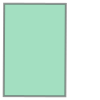

In [12]:
# Check geometry
geom = gdf.iloc[1]["the_geom_4326"]
geom

## 3. Building Visualization

To visualize the buildings of PV rooftops on map, and check its geographic distribution.

In [13]:
import folium
import plotly.graph_objs as go

In [14]:
# Sample datasets, otherwise datasets is too large to show.
samples = gdf.sample(n=10000)

In [15]:
imap = folium.Map(location=[39.0473, -95.6752], zoom_start=11, tiles="Stamen Toner")

# Style function
def style_function(feature):
    return {
        "fillOpacity": 0.75,
        "fillColor": "#00bfff",
        "wight": 0.1,
        "color": "#00bfff"
    }

# GeoJSON
folium.GeoJson(
    name="PV Rooftops",
    data=samples.to_json(),
    style_function=style_function
).add_to(imap)

imap